# RL Env

In [5]:
import base64
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
from torch import nn

from rl import goose_env as ge
from rl import models

%matplotlib inline

In [6]:
obs_type = ge.ObsType.HEAD_CENTERED_OBS_SMALL
reward_type = ge.RewardType.EVERY_STEP_LENGTH

n_channels = [32, 64]
first_downsample = nn.AvgPool2d(2, stride=1)
model_kwargs = dict(conv_block_kwargs=[
    dict(
        in_channels=obs_type.get_obs_spec()[2],
        out_channels=n_channels[0],
        kernel_size=3,
        downsample=nn.Identity()
    ),
    # dict(
    #    in_channels=n_channels[0],
    #    out_channels=n_channels[0],
    #    kernel_size=3,
    #    downsample=nn.Identity(),
    # ),
    dict(
        in_channels=n_channels[0],
        out_channels=n_channels[1],
        kernel_size=3,
        downsample=first_downsample
    ),

    dict(
        in_channels=n_channels[1],
        out_channels=n_channels[1],
        kernel_size=3,
        downsample=nn.Identity(),
    ),
    # dict(
    #    in_channels=n_channels[1],
    #    out_channels=n_channels[1],
    #    kernel_size=3,
    #    downsample=nn.Identity(),
    # ),
    dict(
        in_channels=n_channels[1],
        out_channels=n_channels[1],
        kernel_size=3,
        downsample=nn.AvgPool2d(2),
    )
],
    use_adaptive_avg_pool=False,
    fc_in_channels=n_channels[1] * 3 * 5,
    # fc_in_channels=n_channels[1],
    # **reward_type.get_recommended_value_activation_scale_shift_dict()
)
model = models.DeepQNetwork(
    optimizer_constructor=lambda params: torch.optim.Adam(params,
                                                          # weight_decay=1e-5,
                                                          ),
    epsilon=0.1,
    delayed_updates=True,
    double_q=True,
    dueling_q=True,
    tau=5e-3,
    **model_kwargs
)

with open(f'runs/deep_q/TEMP/0530/cp.txt', 'r') as f:
    serialized_string = f.readline()[2:-1].encode()
state_dict_bytes = base64.b64decode(serialized_string)
loaded_state_dicts = pickle.loads(state_dict_bytes)
model.load_state_dict(loaded_state_dicts)

<All keys matched successfully>

In [87]:
model(torch.from_numpy(s).squeeze(0))

tensor([[ 0.0918,  0.2780,  0.0842,  0.2706],
        [-0.0572,  0.0986, -0.0707,  0.0909],
        [-0.0043,  0.1071, -0.0141,  0.0976],
        [-0.1164,  0.0430, -0.1310,  0.0333]], grad_fn=<AddBackward0>)

In [109]:
env = ge.GooseEnvVectorized(ge.ObsType.HEAD_CENTERED_OBS, ge.RewardType.RANK_ON_DEATH, n_envs=1)
s, r, d, info_dict = env.hard_reset()
for i in range(39):
    s, r, d, info_dict = env.step(np.zeros((env.n_envs, env.n_players), dtype=np.int64))
env.wrapped_envs[0].render(mode='ipython', width=800, height=700)

In [122]:
n_geese = 4
new_other_goose_idxs = np.random.permutation(np.arange(1, n_geese))
new_channel_idxs_full = np.concatenate([
    np.arange(11),
    (new_other_goose_idxs[:, np.newaxis] * 11 + np.arange(11)).ravel(),
    np.arange(n_geese * 11, n_geese * 11 + 3)
])
s = s[:, :, new_channel_idxs_full]

In [131]:
n_geese = 4
flippable_channel_idxs = np.arange(n_geese * 11)
flippable_channel_idxs = np.where(
    np.logical_or(flippable_channel_idxs % 11 == 4, flippable_channel_idxs % 11 == 8),
    flippable_channel_idxs + 2,
    np.where(
        np.logical_or(flippable_channel_idxs % 11 == 6, flippable_channel_idxs % 11 == 10),
        flippable_channel_idxs - 2,
        flippable_channel_idxs
    )
)
flippable_channel_idxs

array([ 0,  1,  2,  3,  6,  5,  4,  7, 10,  9,  8, 11, 12, 13, 14, 17, 16,
       15, 18, 21, 20, 19, 22, 23, 24, 25, 28, 27, 26, 29, 32, 31, 30, 33,
       34, 35, 36, 39, 38, 37, 40, 43, 42, 41])

In [127]:
torch.arange(4).unsqueeze(0).expand(2, -1)[[True, True, True, True], [False, True, True, True]]

IndexError: The shape of the mask [4] at index 0 does not match the shape of the indexed tensor [2, 4] at index 0

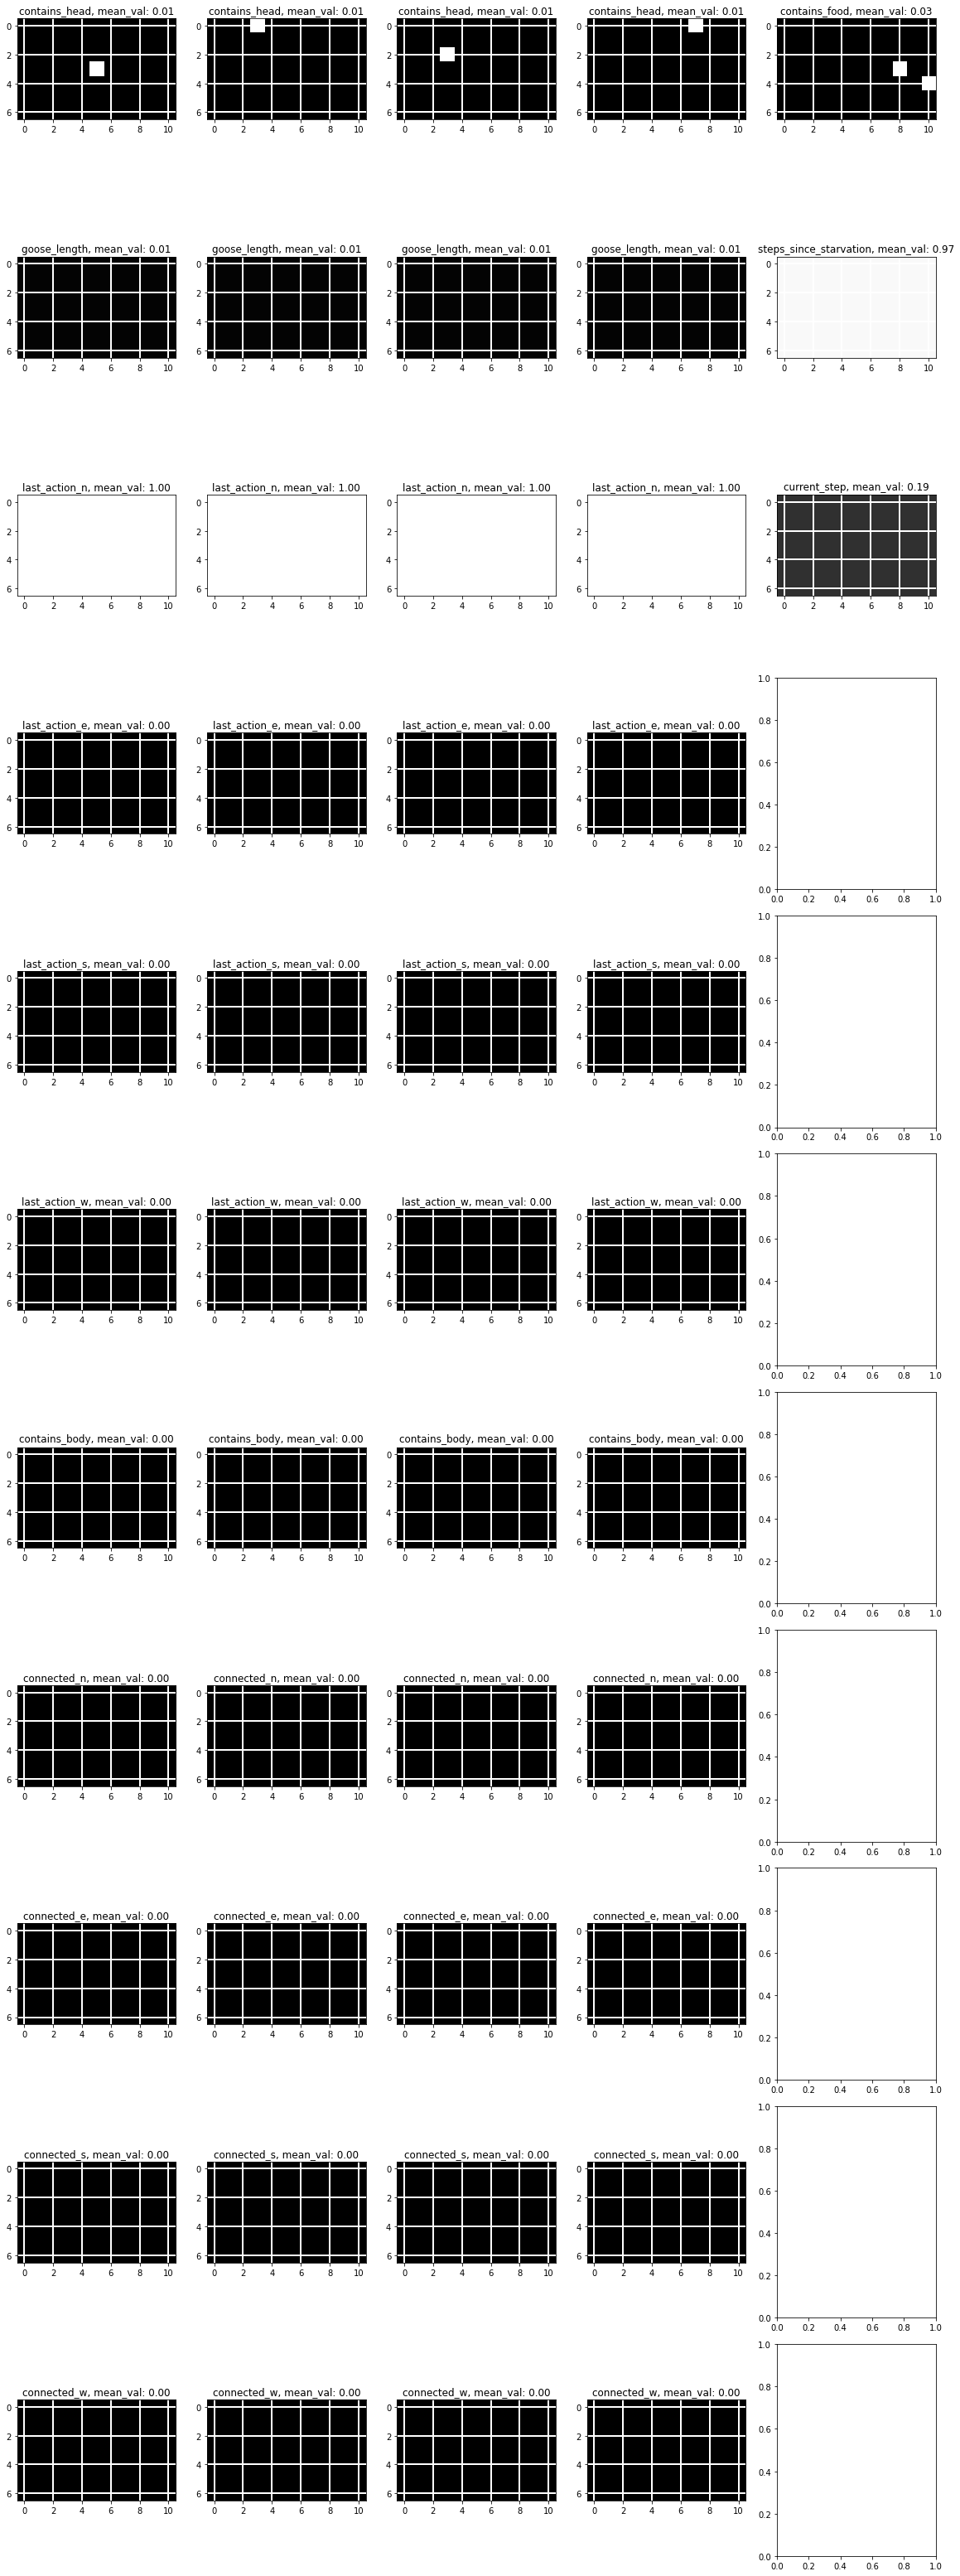

In [123]:
player_channel_list = [
    'contains_head',
    'goose_length',
    'last_action_n',
    'last_action_e',
    'last_action_s',
    'last_action_w',
    'contains_body',
    'connected_n',
    'connected_e',
    'connected_s',
    'connected_w',
]


figsize_mult = 4
fig, axes = plt.subplots(nrows=len(player_channel_list), ncols=5, figsize=(4 * figsize_mult, len(player_channel_list) * figsize_mult))
for ax in axes.ravel():
    ax.grid(color='w', linestyle='-', linewidth=2)

main_player = 3
for player_idx in range(4):
    for channel_idx, channel in enumerate(player_channel_list):
        img_channel = player_idx * len(player_channel_list) + channel_idx
        axes[channel_idx, player_idx].imshow(s[0, main_player, img_channel], cmap='gray', vmin=0., vmax=1.)
        axes[channel_idx, player_idx].set_title(f'{channel}, mean_val: {s[0, 0, img_channel].mean():.2f}')
axes[0, 4].imshow(s[0, main_player, -3], cmap='gray', vmin=0., vmax=1.)
axes[0, 4].set_title(f'contains_food, mean_val: {s[0, 0, -3].mean():.2f}')
axes[1, 4].imshow(s[0, main_player, -2], cmap='gray', vmin=0., vmax=1.)
axes[1, 4].set_title(f'steps_since_starvation, mean_val: {s[0, 0, -2].mean():.2f}')
axes[2, 4].imshow(s[0, main_player, -1], cmap='gray', vmin=0., vmax=1.)
axes[2, 4].set_title(f'current_step, mean_val: {s[0, 0, -1].mean():.2f}')
plt.tight_layout();

# Kaggle Env

In [1]:
import numpy as np
import random
from kaggle_environments import make
from kaggle_environments.envs.hungry_geese.hungry_geese import Observation, Configuration, Action, row_col

env = make("hungry_geese")

Loading environment football failed: No module named 'gfootball'


In [2]:
def random_action(obs, step, player):
    """Choose action randomly considering available actions"""
    prev_action = obs[player]['action']
    observation = obs[player]['observation']

    # Check legal(available) actions
    legal_actions = ['NORTH', 'SOUTH', 'WEST', 'EAST']
    if step != 0:
        legal_actions.remove(Action[prev_action].opposite().name)

    return random.choice(legal_actions)

In [3]:
# Run reset and step until the end

# The number of agents
NUM_AGENTS = 4

# Reset environment
observations = env.reset(num_agents=NUM_AGENTS)

while not env.done:
    # Game step
    step = observations[0]['observation']['step']
    # Get random actions for each agent
    actions = [random_action(observations, step, p) for p in range(NUM_AGENTS)]
    # Play actions
    observations = env.step(actions)

display(observations)
[agent['reward'] % (99. + 1.) for agent in env.steps[-1]], [agent['reward'] // (99. + 1.) for agent in env.steps[-1]]

[{'action': 'EAST',
  'reward': 201,
  'info': {},
  'observation': {'remainingOverageTime': 60,
   'step': 99,
   'geese': [[], [5, 6], [], []],
   'food': [33, 42],
   'index': 0},
  'status': 'DONE'},
 {'action': 'WEST',
  'reward': 10002,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 1},
  'status': 'DONE'},
 {'action': 'EAST',
  'reward': 9901,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 2},
  'status': 'DONE'},
 {'action': 'NORTH',
  'reward': 201,
  'info': {},
  'observation': {'remainingOverageTime': 60, 'index': 3},
  'status': 'DONE'}]

([1.0, 2.0, 1.0, 1.0], [2.0, 100.0, 99.0, 2.0])